Notebook By: **Cameron Craig**, for ECE 697

This python notebook generates a preset number of synthetic "Bias Fields." These fields will be saved as pickled numpy arrays (yum). These arrays will go on to be read by a Pytorch Dataset object, where they will be multiplied by homogeneous MRI images to simulate the effect of a single posterior coil array capturing the data.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
from tqdm import tqdm
from joblib import Parallel, delayed
import random

---

In [2]:
# Fixed Model Parameters
SIZE = (320, 320) # (Height, Width) of the generated bias field
num_points = 60 # resolution of the simulated coil array

# Exponential Curve Parameters - Based on Physical Measurements - No longer used
'''
a = 0.373662089
b = 0.0294170684
c = 57.7187808
d = 0.1090366275
'''

# Uniform Random Variable Bounds
LOW_BOOST_BOUNDS = (0, 0.2)
COIL_VERT_POS_BOUNDS = (SIZE[0] - 1, SIZE[0] * 1.2)
PARAM_B_ADJUST_BOUNDS = (-0.02, 0.02)
COIL_WIDTH_BOUNDS = (0.1, 0.4)

In [3]:
# Helper Functions

# Parameterized exponential decay function - No longer used
#def exp_dec(x, a, b, c, d):
#  return a*(1 - b)**(x - c) + d

# Inverse square decay function - Values selected based on analysis of experimental results
def poly_dec(x):
  return 1927.5 * (x + 37)**-2.093

# Normalize pixel values to the range [0, 1]
def normalize(image):
  new_image = image - np.min(image)
  return new_image / np.max(new_image)

# Obtain a sample of a uniform random variable on the specified bounds
def sampleRV(BOUNDS):
  return np.random.uniform(BOUNDS[0], BOUNDS[1])

In [4]:
# Test run
poly_dec(0)

1.0063479778204567

In [5]:
#Create a Bias Field
def genBiasField(SIZE, coil_left, coil_right, coil_vert_pos, low_boost):
  global a, b, c, d

  # Define Coil Shape
  cx = np.linspace(round(SIZE[1]*coil_left), round(SIZE[1]*coil_right), num=num_points) # Horizontal coordinates

  # Put coil array at or below bottom edge of bias field
  y_pos = round(coil_vert_pos)
  cy = np.linspace(y_pos, y_pos, num=num_points) # Vertical coordinates

  coils = np.stack([cy, cx], axis=0).T # Reshape to prepare for arithmetic operations

  B = np.zeros(SIZE)
  dists = np.zeros((coils.shape[0],)) # Distances between coil points and field points

  # Loop over all pixels in B
  for i in range(B.shape[0]):
    for j in range(B.shape[1]):
      # Stack of copies of this point's coordinates
      p = np.array([i, j])
      p = np.tile(p, (num_points, 1))

      # Get the distance between this point and the closest coil point
      dist = np.min(np.linalg.norm(coils - p, axis=1))

      # Simulate exponential falloff
      #B[i, j] = exp_dec(dist, a, local_b, c, d) - no longer used
      B[i, j] = poly_dec(dist)
  
  # Normalize B on range [0, 1]
  B_norm = normalize(B)

  # Scale up / boost the weak end intensity of the field
  B_boosted = B_norm * (1 - low_boost) + low_boost

  return B_boosted

In [6]:
# This function generates a more complicated bias field by combining multiple simpler bias fields
def genCompositeField(SIZE):
  num_coils = random.randint(1, 3)

  coil_width = sampleRV(COIL_WIDTH_BOUNDS)

  # If there will only be 1 coil then we want it to be a little wider for realism
  if num_coils == 1:
    coil_width += 0.1
  
  # set the horizontal extent of coil array
  coil_left_bound, coil_right_bound = 0.5 - coil_width, 0.5 + coil_width

  # allocate space for each individual field
  sub_fields = np.zeros((num_coils, SIZE[0], SIZE[1]))

  # set/sample parameter values for field generation
  c_fraction = 1. / num_coils
  vert_pos = sampleRV(COIL_VERT_POS_BOUNDS)
  low_boost = sampleRV(LOW_BOOST_BOUNDS)

  # Generate each sub-field
  for i in range(num_coils):
    sub_fields[i, :, :] = genBiasField(SIZE, coil_left_bound*c_fraction + i*c_fraction, coil_right_bound*c_fraction + i*c_fraction, vert_pos, low_boost)

  # Average the sub-fields together to create one composite field
  return sub_fields.mean(axis=0)

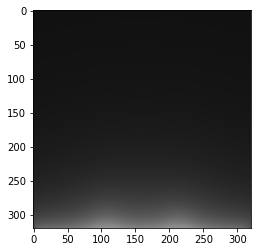

In [8]:
# Create and view a sample composite bias field
num_coils = random.randint(1, 3)

coil_width = sampleRV(COIL_WIDTH_BOUNDS)
if num_coils == 1:
  coil_width += 0.1
coil_left_bound, coil_right_bound = 0.5 - coil_width, 0.5 + coil_width # horizontal extent of coil array
sub_fields = np.zeros((num_coils, SIZE[0], SIZE[1]))
c_fraction = 1. / num_coils
vert_pos = sampleRV(COIL_VERT_POS_BOUNDS)
low_boost = sampleRV(LOW_BOOST_BOUNDS)

for i in range(num_coils):
  sub_fields[i, :, :] = genBiasField(SIZE, coil_left_bound*c_fraction + i*c_fraction, coil_right_bound*c_fraction + i*c_fraction, vert_pos, low_boost)

B = sub_fields.mean(axis=0)


plt.imshow(B, cmap='gray', vmin=0, vmax=1)

In [ ]:
# Generate bias field samples for training
NUM_FIELDS = 5000

#!mkdir ./fields
dir_path = r'/content/drive/MyDrive/Summer 2022/ECE 697/Project/share/data/synth_bias_fields'


fields = Parallel(n_jobs=12)(delayed(genCompositeField)(SIZE) for i in tqdm(range(NUM_FIELDS)))


with open(os.path.join(dir_path, 'fields_5k_poly_train.pkl'), 'wb') as curr_file:
  pkl.dump(fields, curr_file)

100%|██████████| 5000/5000 [2:02:30<00:00,  1.47s/it]


In [ ]:
# Generate bias field samples for validation
NUM_FIELDS = 5000

#!mkdir ./fields
dir_path = r'/content/drive/MyDrive/Summer 2022/ECE 697/Project/share/data/synth_bias_fields'


fields = Parallel(n_jobs=12)(delayed(genCompositeField)(SIZE) for i in tqdm(range(NUM_FIELDS)))


with open(os.path.join(dir_path, 'fields_5k_poly_val.pkl'), 'wb') as curr_file:
  pkl.dump(fields, curr_file)

100%|██████████| 5000/5000 [2:04:21<00:00,  1.49s/it]


In [ ]:
# Generate bias field samples for testing
NUM_FIELDS = 5000

#!mkdir ./fields
dir_path = r'/content/drive/MyDrive/Summer 2022/ECE 697/Project/share/data/synth_bias_fields'


fields = Parallel(n_jobs=12)(delayed(genCompositeField)(SIZE) for i in tqdm(range(NUM_FIELDS)))


with open(os.path.join(dir_path, 'fields_5k_poly_test.pkl'), 'wb') as curr_file:
  pkl.dump(fields, curr_file)

100%|██████████| 5000/5000 [2:04:16<00:00,  1.49s/it]


Generate smaller number of fields as a sample to upload to Github.

In [9]:
# Generate bias field samples for Github upload
NUM_FIELDS = 25

#!mkdir ./fields
dir_path = r'/content/'


fields = Parallel(n_jobs=12)(delayed(genCompositeField)(SIZE) for i in tqdm(range(NUM_FIELDS)))


with open(os.path.join(dir_path, '25_sample_synth_bias_fields.pkl'), 'wb') as curr_file:
  pkl.dump(fields, curr_file)

100%|██████████| 25/25 [00:09<00:00,  2.74it/s]
